#### LOADING THE DATASET 

In [3]:
import pandas as pd

df = pd.read_csv('Downloads/hocco_sales_data_23 1.csv')

# Group by 'itemid' and count the number of occurrences
item_counts = df['itemid'].value_counts()

print(item_counts)
df.head()

itemid
SFG648     701
R00513     700
SFG152     698
A00123     697
R00526     697
          ... 
SFG588       1
SFG374       1
SFG370       1
SFG373       1
RMD0651      1
Name: count, Length: 1112, dtype: int64


,itemid,orderdate,qty,amount
0,SFG633,01-01-2022,9.0,270.09
1,6010101,01-01-2022,6.0,408.84
2,R00010,01-01-2022,40.0,2176.20
3,R00429,01-01-2022,21.0,1387.75
4,RMD0460,01-01-2022,15.0,486.00


####  TOP 5 ITEMID WITH MAX 

'SFG648',  'R00513',  'SFG152','A00123','R00526'

##### CHANGING THE DATATYPE OF OREDTEDATE COLUMN TO DATETIME DATATYPE

In [6]:
df['orderdate'] = pd.to_datetime(df['orderdate'], format = "%d-%m-%Y")
df.set_index('orderdate', inplace=True)

df.head()

,itemid,qty,amount
orderdate,,,
2022-01-01,SFG633,9.0,270.09
2022-01-01,6010101,6.0,408.84
2022-01-01,R00010,40.0,2176.20
2022-01-01,R00429,21.0,1387.75
2022-01-01,RMD0460,15.0,486.00


In [7]:
# Resample the data to daily frequency and sum the 'amount'
daily_data = df['amount'].resample('D').sum()

# Print the first few rows to verify
daily_data.head()

orderdate
2022-01-01    189430.75
2022-01-02    262071.03
2022-01-03    485115.78
2022-01-04    285112.21
2022-01-05    254594.86
Freq: D, Name: amount, dtype: float64

# FORECASTING FOR DECEMBER 2023

### FUNCTION TO FORECAST AMOUNT FOR EACH ITEMID IN DEC2023

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

def forecast_and_evaluate(daily_data, item_id, start_date='2023-12-01', end_date='2023-12-31'):
    # Filter data for the given item_id
    item_data = daily_data[daily_data['itemid'] == item_id].copy()

    # Convert 'orderdate' to datetime format and set it as index
    item_data['orderdate'] = pd.to_datetime(item_data['orderdate'], format="%d-%m-%Y")
    item_data.set_index('orderdate', inplace=True)

    # Resample the data to daily frequency and sum the 'amount'
    daily_data = item_data['amount'].resample('D').sum()

    # Split data into training and test sets based on the provided dates
    train_data = daily_data[:pd.to_datetime(start_date) - pd.DateOffset(days=1)]
    test_data = daily_data[start_date:end_date]

    # Find the best ARIMA model parameters on the training data
    model = auto_arima(train_data, seasonal=False, trace=True, 
                       error_action='ignore', suppress_warnings=True)

    # Print the summary of the model to see the selected parameters
    print(f"Item ID: {item_id}")
    print(model.summary())

    # Get the order of the ARIMA model from auto_arima
    order = model.order

    # Fit the ARIMA model with the optimal parameters
    arima_model = sm.tsa.ARIMA(train_data, order=order)
    fitted_model = arima_model.fit()

    # Forecast for the specified period
    forecast_steps = len(test_data)
    forecast = fitted_model.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=start_date, periods=forecast_steps, freq='D')

    # Extract forecasted values and confidence intervals
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()

    # Create a DataFrame for the forecasted results
    forecast_df = pd.DataFrame({
        'date': forecast_index,
        'forecast': forecast_values,
    })

    # Merge forecast results with actual test data
    test_data_df = test_data.reset_index().rename(columns={'amount': 'actual'})
    comparison_df = pd.merge(forecast_df, test_data_df, left_on='date', right_on='orderdate', how='left')

    # Print the comparison results
    print(comparison_df)

    # Plot the actual and forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df['date'], comparison_df['actual'], label='Actual Amount', color='blue', marker='o')
    plt.plot(comparison_df['date'], comparison_df['forecast'], label='Forecasted Amount', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.title(f'Actual vs Forecasted Amount for {item_id} from {start_date} to {end_date}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate accuracy metrics
    actual_values = comparison_df['actual']
    forecasted_values = comparison_df['forecast']

    # Handle missing values in actual data
    if actual_values.isnull().any():
        actual_values = actual_values.dropna()
        forecasted_values = forecasted_values.loc[actual_values.index]

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, forecasted_values)
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, forecasted_values)
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Print the accuracy metrics
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    return forecast_df, comparison_df, mae, mse, rmse


#### LOOP FOR FORECASTING AMOUNT IN DEC2023 ITEMID WISE DYNAMICALLY FOR ITEMID WITH MAX FREQUENCY

Processing item ID: SFG648
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13458.906, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13234.214, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13456.907, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13011.345, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12880.490, Time=0.36 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=12875.363, Time=0.43 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=12869.412, Time=0.38 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=12758.137, Time=1.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12763.513, Time=1.33 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12777.313, Time=2.12 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=12758.600, Time=0.78 sec

Best mode

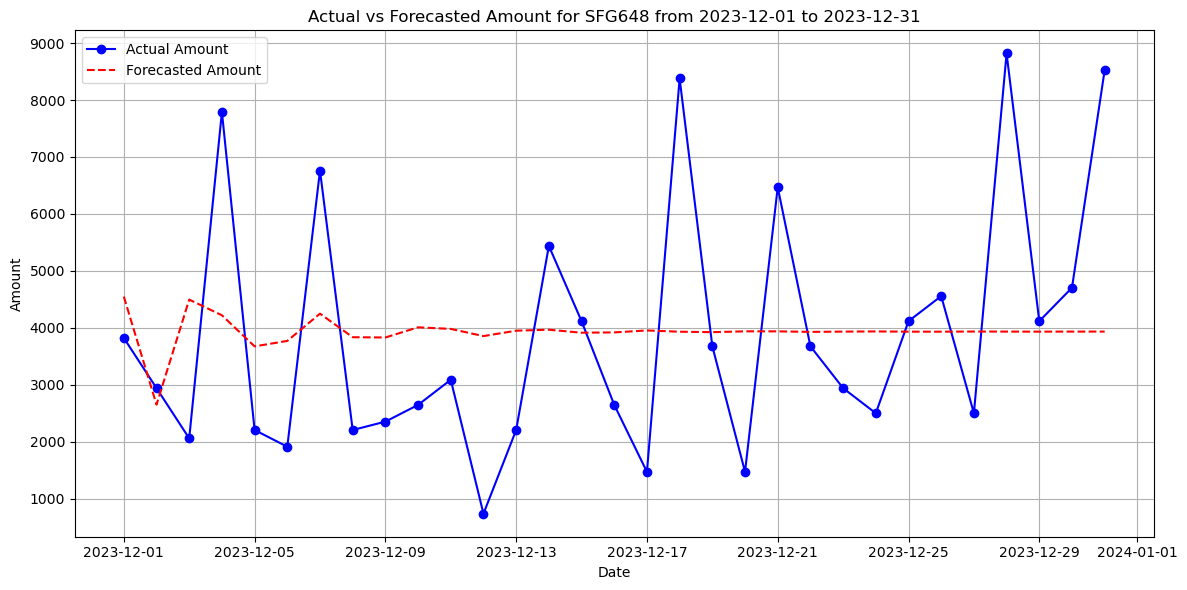

Mean Absolute Error (MAE): 1728.3419821814668
Mean Squared Error (MSE): 4678431.207723883
Root Mean Squared Error (RMSE): 2162.9681476443156
Item ID: SFG648 - MAE: 1728.3419821814668, MSE: 4678431.207723883, RMSE: 2162.9681476443156
Processing item ID: R00513
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16721.222, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16497.064, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16719.224, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16199.961, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16013.890, Time=0.26 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=16002.451, Time=0.30 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=15967.183, Time=0.37 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.73 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf

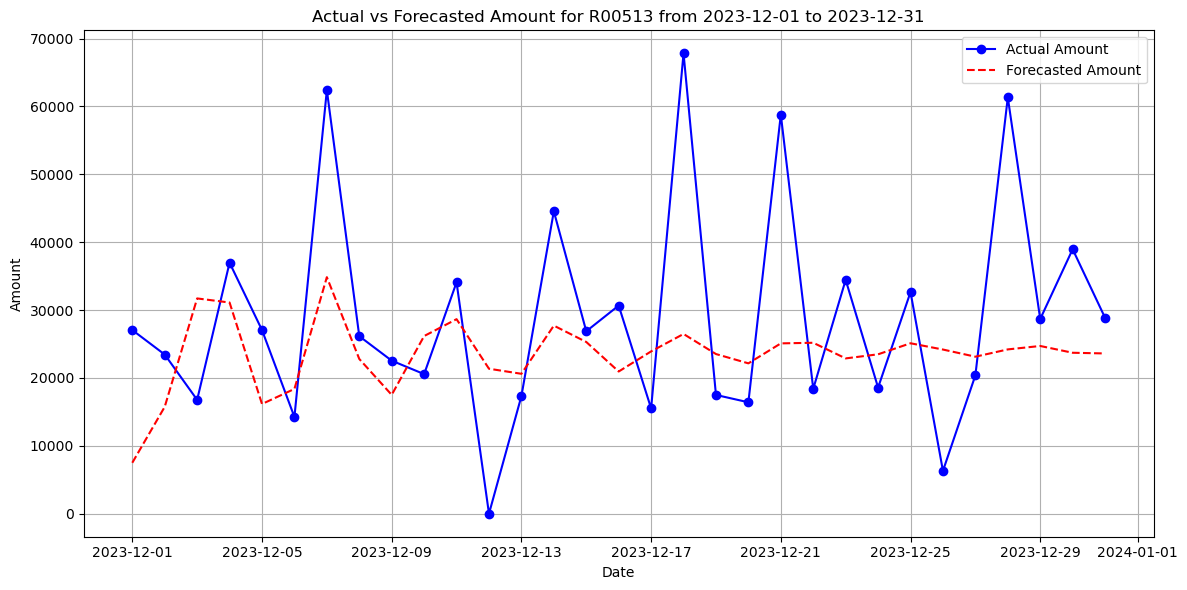

Mean Absolute Error (MAE): 11972.61716043145
Mean Squared Error (MSE): 250610731.52328983
Root Mean Squared Error (RMSE): 15830.689546677675
Item ID: R00513 - MAE: 11972.61716043145, MSE: 250610731.52328983, RMSE: 15830.689546677675
Processing item ID: SFG152
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13694.105, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13493.773, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13692.106, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13266.208, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13160.215, Time=0.31 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=13159.508, Time=0.38 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=13157.284, Time=0.40 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf

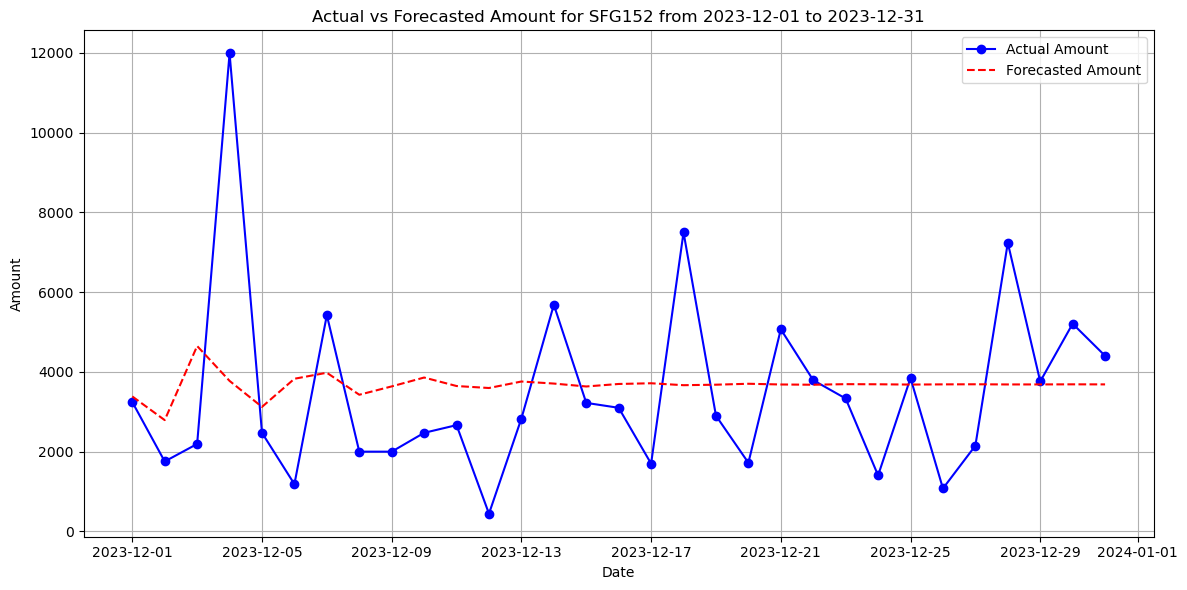

Mean Absolute Error (MAE): 1678.432390193869
Mean Squared Error (MSE): 5235224.751658664
Root Mean Squared Error (RMSE): 2288.0613522496865
Item ID: SFG152 - MAE: 1678.432390193869, MSE: 5235224.751658664, RMSE: 2288.0613522496865
Processing item ID: A00123
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11624.709, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12466.746, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12175.533, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11791.333, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12464.749, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11641.365, Time=1.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11637.936, Time=1.71 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11637.500, Time=2.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11598.098, Time=2.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11643.386, Time=2.24 sec
 ARIMA(3,1,3)(0,0,0)[0] inter

C:\Users\Vishwa.Pujara\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vishwa.Pujara\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         date     forecast  orderdate  actual
0  2023-12-01   925.478535 2023-12-01  2138.4
1  2023-12-02  2128.467470 2023-12-02  2405.7
2  2023-12-03  1645.628909 2023-12-03  1989.9
3  2023-12-04  4018.895386 2023-12-04  3504.6
4  2023-12-05   140.890671 2023-12-05  1782.0
5  2023-12-06  1753.059891 2023-12-06  2197.8
6  2023-12-07  3993.141775 2023-12-07  3950.1
7  2023-12-08   734.850220 2023-12-08  2049.3
8  2023-12-09  1998.916519 2023-12-09  2702.7
9  2023-12-10  1647.032468 2023-12-10  2257.2
10 2023-12-11  3959.347862 2023-12-11  3979.8
11 2023-12-12   169.918194 2023-12-12     0.0
12 2023-12-13  1738.441829 2023-12-13  2524.5
13 2023-12-14  3976.217260 2023-12-14  3118.5
14 2023-12-15   765.868784 2023-12-15  3237.3
15 2023-12-16  1963.201034 2023-12-16  3623.4
16 2023-12-17  1685.481676 2023-12-17  1247.4
17 2023-12-18  3917.389302 2023-12-18  3474.9
18 2023-12-19   204.379874 2023-12-19  1247.4
19 2023-12-20  1727.293954 2023-12-20  2168.1
20 2023-12-21  3960.486465 2023-12

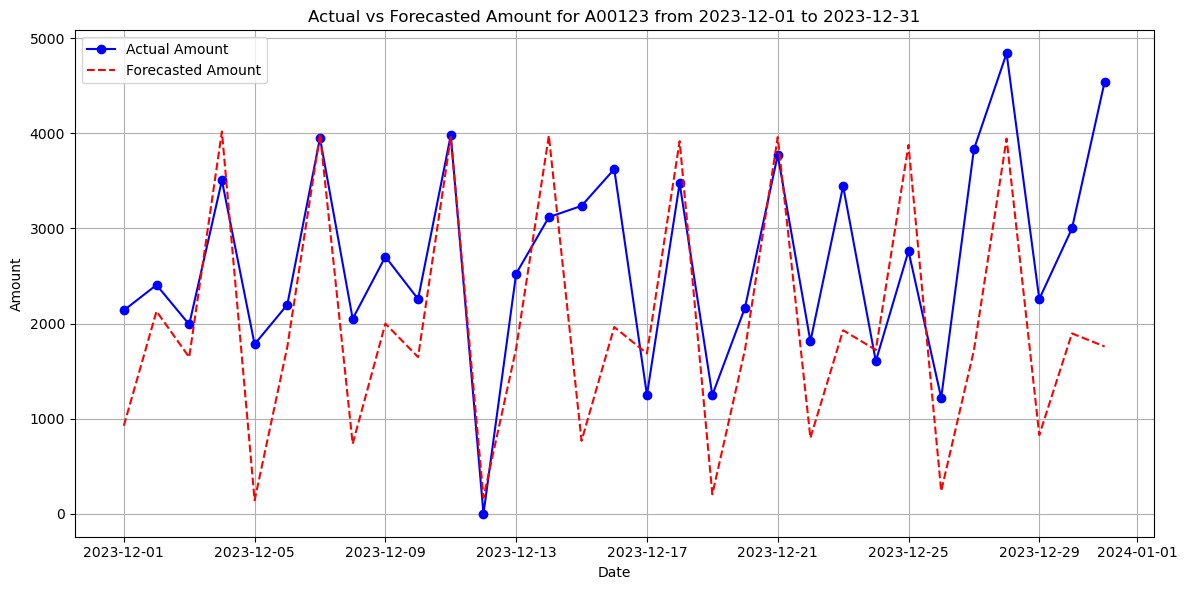

Mean Absolute Error (MAE): 925.8340517552085
Mean Squared Error (MSE): 1329659.2560089275
Root Mean Squared Error (RMSE): 1153.1085187478789
Item ID: A00123 - MAE: 925.8340517552085, MSE: 1329659.2560089275, RMSE: 1153.1085187478789


In [55]:
def process_top_items(df, top_n=4):
    # Determine the frequency of each item_id
    item_counts = df['itemid'].value_counts()
    
    # Select the top N item_ids with the highest frequency
    top_items = item_counts.head(top_n).index
    
    for item_id in top_items:
        # Filter and forecast for each item_id
        print(f"Processing item ID: {item_id}")
        forecast_df, comparison_df, mae, mse, rmse = forecast_and_evaluate(df, item_id)
        # Optionally, save forecast_df and comparison_df to CSV
        forecast_df.to_csv(f'{item_id}_forecast.csv', index=False)
        comparison_df.to_csv(f'{item_id}_comparison.csv', index=False)
        # Print the metrics
        print(f"Item ID: {item_id} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# Load data and process the top items
df = pd.read_csv('Downloads/hocco_sales_data_23 1.csv')
process_top_items(df)

#### LOOP FOR FORECASTING AMOUNT IN DEC2023 ITEMID WISE DYNAMICALLY FOR ALL ITEID

Processing item ID: SFG633
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8456.884, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8351.996, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8392.046, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8289.400, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8252.081, Time=0.23 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8208.466, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8209.847, Time=0.12 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8113.422, Time=0.82 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8111.466, Time=0.96 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8109.602, Time=0.58 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8109.563, Time=0.52 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8355.680, Time=0.23 sec
 ARIMA(1,0,3)(0,

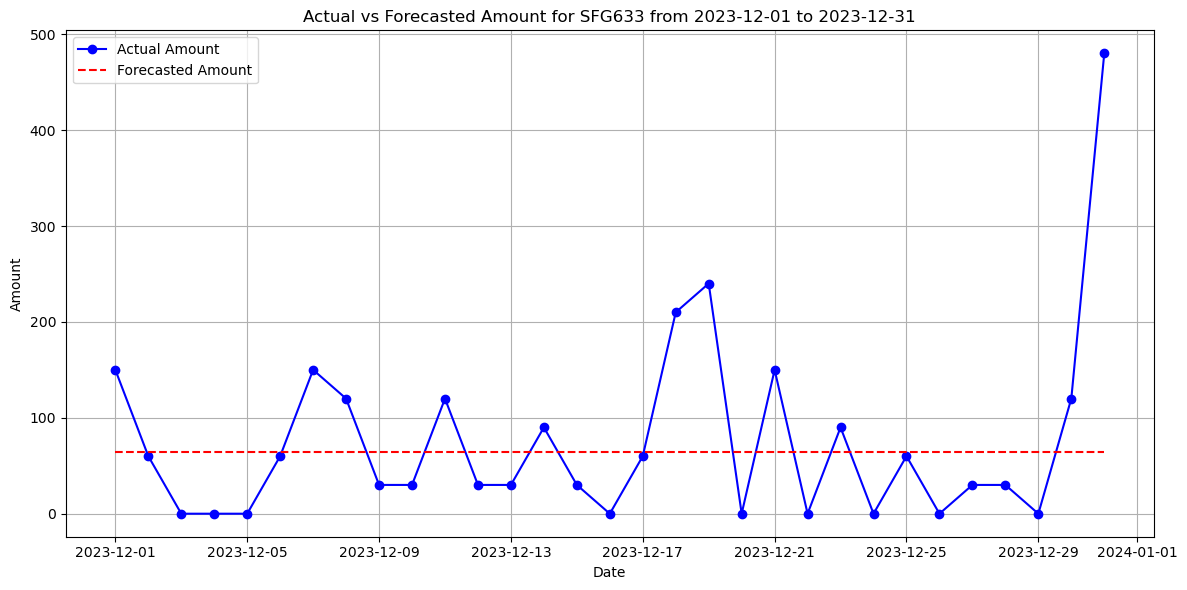

Mean Absolute Error (MAE): 66.26422173062656
Mean Squared Error (MSE): 9770.823029814579
Root Mean Squared Error (RMSE): 98.84747356313453
Item ID: SFG633 - MAE: 66.26422173062656, MSE: 9770.823029814579, RMSE: 98.84747356313453
Processing item ID: 6010101
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16666.422, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16645.280, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16649.439, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16637.861, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=16622.149, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=16621.674, Time=0.11 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=16620.621, Time=0.20 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=1.62 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=1.04 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=16558.

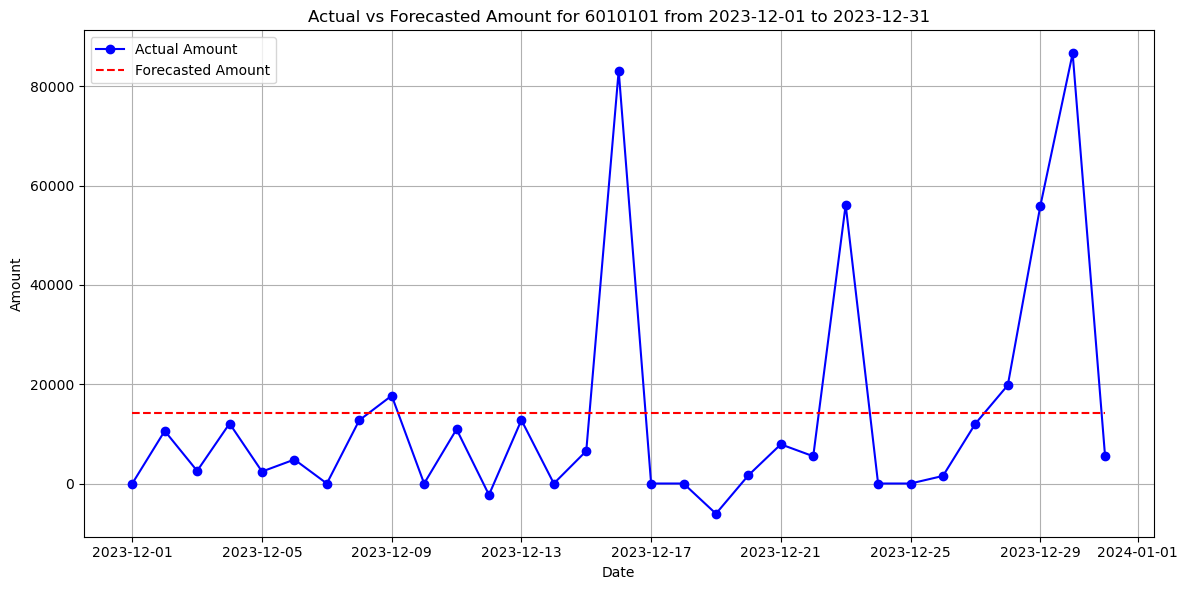

Mean Absolute Error (MAE): 15757.054293229956
Mean Squared Error (MSE): 542007030.8561912
Root Mean Squared Error (RMSE): 23281.044453722243
Item ID: 6010101 - MAE: 15757.054293229956, MSE: 542007030.8561912, RMSE: 23281.044453722243
Processing item ID: R00010
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11638.124, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12205.312, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12105.956, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12203.313, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11635.792, Time=1.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11709.252, Time=1.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11891.923, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11637.527, Time=1.65 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : 

C:\Users\Vishwa.Pujara\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Vishwa.Pujara\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


         date     forecast  orderdate  actual
0  2023-12-01  2071.327832 2023-12-01  2604.0
1  2023-12-02  2391.655545 2023-12-02  1736.0
2  2023-12-03  2383.942438 2023-12-03  2666.0
3  2023-12-04  2479.071688 2023-12-04  2294.0
4  2023-12-05  2327.700842 2023-12-05   620.0
5  2023-12-06  2429.957842 2023-12-06  2356.0
6  2023-12-07  2374.017948 2023-12-07  3162.0
7  2023-12-08  2418.697523 2023-12-08  2604.0
8  2023-12-09  2377.430155 2023-12-09  1984.0
9  2023-12-10  2409.882921 2023-12-10  3038.0
10 2023-12-11  2386.497546 2023-12-11  2232.0
11 2023-12-12  2404.284786 2023-12-12     0.0
12 2023-12-13  2390.043510 2023-12-13  2480.0
13 2023-12-14  2401.236758 2023-12-14  3348.0
14 2023-12-15  2392.663660 2023-12-15  3286.0
15 2023-12-16  2399.256168 2023-12-16  2170.0
16 2023-12-17  2394.121981 2023-12-17  1922.0
17 2023-12-18  2398.120845 2023-12-18  2542.0
18 2023-12-19  2395.024262 2023-12-19     0.0
19 2023-12-20  2397.419800 2023-12-20  2666.0
20 2023-12-21  2395.561926 2023-12

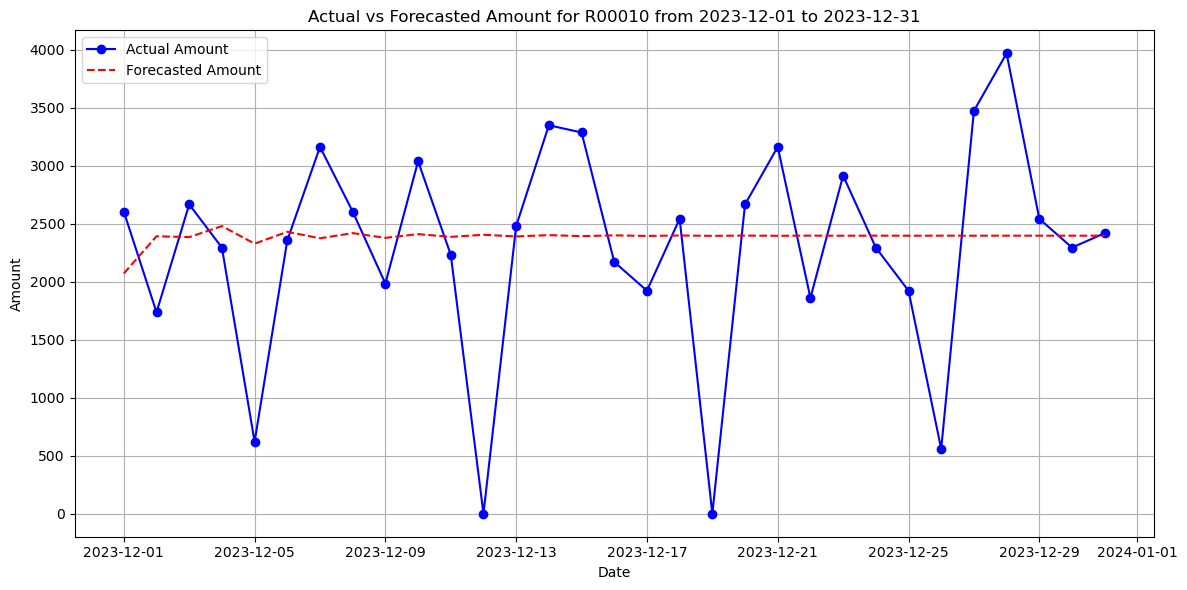

Mean Absolute Error (MAE): 663.9938129699932
Mean Squared Error (MSE): 870459.7288231589
Root Mean Squared Error (RMSE): 932.9843132781809
Item ID: R00010 - MAE: 663.9938129699932, MSE: 870459.7288231589, RMSE: 932.9843132781809
Processing item ID: R00429
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12346.059, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12091.324, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12190.038, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11995.063, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11784.790, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=11686.452, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=11685.911, Time=0.24 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=11649.456, Time=1.45 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=11686.694, Time=0.37 sec
 ARIMA(5,0,2)(0,0,0)[0]             :

C:\Users\Vishwa.Pujara\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         date     forecast  orderdate  actual
0  2023-12-01  1494.561717 2023-12-01  1501.5
1  2023-12-02   554.760631 2023-12-02   429.0
2  2023-12-03  1542.009055 2023-12-03  1573.0
3  2023-12-04  2036.139471 2023-12-04  1072.5
4  2023-12-05   839.571681 2023-12-05  1001.0
5  2023-12-06   858.919752 2023-12-06   643.5
6  2023-12-07  2029.048410 2023-12-07  2574.0
7  2023-12-08  1475.669653 2023-12-08  1072.5
8  2023-12-09   545.271498 2023-12-09  1072.5
9  2023-12-10  1499.330312 2023-12-10   929.5
10 2023-12-11  1995.078679 2023-12-11  1144.0
11 2023-12-12   819.365835 2023-12-12     0.0
12 2023-12-13   842.836303 2023-12-13   715.0
13 2023-12-14  1999.360257 2023-12-14  1573.0
14 2023-12-15  1460.133984 2023-12-15  1001.0
15 2023-12-16   545.749847 2023-12-16   929.5
16 2023-12-17  1486.566549 2023-12-17   715.0
17 2023-12-18  1978.226492 2023-12-18  1644.5
18 2023-12-19   822.414873 2023-12-19   643.5
19 2023-12-20   844.886592 2023-12-20   214.5
20 2023-12-21  1985.019326 2023-12

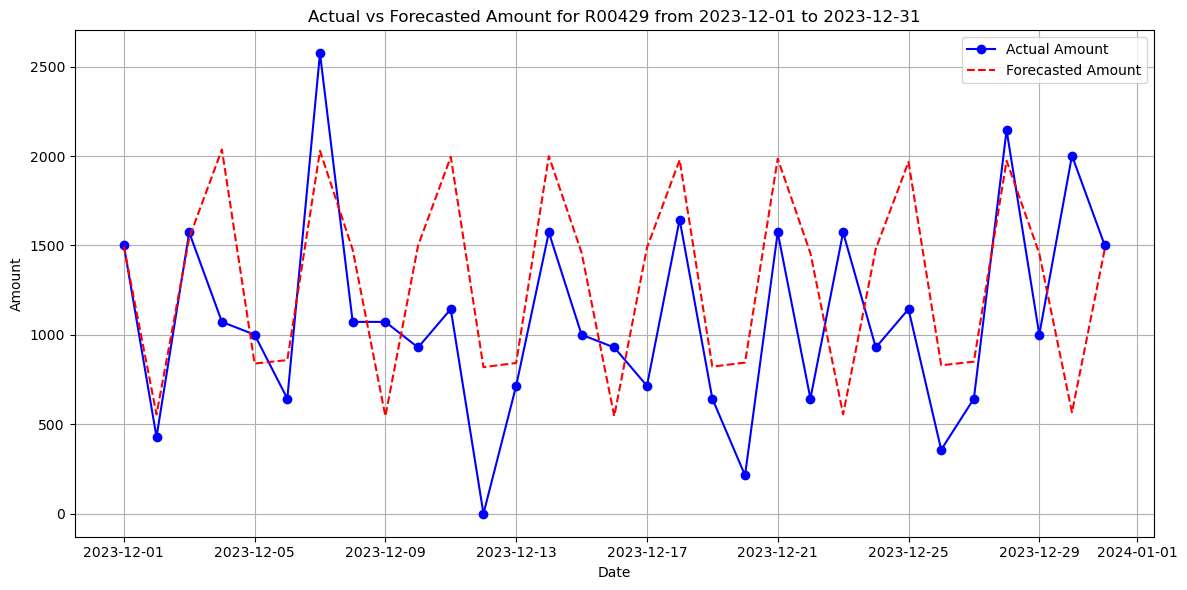

Mean Absolute Error (MAE): 481.0619735052961
Mean Squared Error (MSE): 341234.13628064236
Root Mean Squared Error (RMSE): 584.1524940292923
Item ID: R00429 - MAE: 481.0619735052961, MSE: 341234.13628064236, RMSE: 584.1524940292923
Processing item ID: RMD0460
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6039.902, Time=1.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6263.875, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6174.892, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6198.097, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6044.772, Time=0.74 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6044.773, Time=0.88 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6036.745, Time=1.35 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6033.751, Time=0.91 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=6116.910, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=6035.436, Time=1.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : 

ValueError: Prediction must have `end` after `start`.

In [31]:
"""
# List or range of itemid values to process
itemid_list = df['itemid'].unique() 

def process_top_items(df, itemid_list):
    # Determine the frequency of each item_id
    item_counts = df['itemid'].value_counts()
    
    """# Select the top N item_ids with the highest frequency
    top_items = item_counts.head(itemid_list).index"""
    
    for item_id in itemid_list:
        # Filter and forecast for each item_id
        print(f"Processing item ID: {item_id}")
        forecast_df, comparison_df, mae, mse, rmse = forecast_and_evaluate(df, item_id)
        # Optionally, save forecast_df and comparison_df to CSV
        forecast_df.to_csv(f'{item_id}_forecast.csv', index=False)
        comparison_df.to_csv(f'{item_id}_comparison.csv', index=False)
        # Print the metrics
        print(f"Item ID: {item_id} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# Load data and process the top items
df = pd.read_csv('Downloads/hocco_sales_data_23 1.csv')
process_top_items(df,itemid_list)
"""

# PREDICTION FOR JANUARY 2024

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import statsmodels.api as sm

def forecast_future_period(daily_data, item_id, start_date='2024-01-01', end_date='2024-01-31'):
    # Filter data for the given item_id
    item_data = daily_data[daily_data['itemid'] == item_id].copy()

    # Convert 'orderdate' to datetime format and set it as index
    item_data['orderdate'] = pd.to_datetime(item_data['orderdate'], format="%d-%m-%Y")
    item_data.set_index('orderdate', inplace=True)

    # Resample the data to daily frequency and sum the 'amount'
    daily_data = item_data['amount'].resample('D').sum()

    # Split data into training set up to the end of December 2023
    train_data = daily_data[:'2023-12-31']

    # Find the best ARIMA model parameters
    model = auto_arima(train_data, seasonal=False, trace=True, 
                       error_action='ignore', suppress_warnings=True)

    # Print the summary of the model to see the selected parameters
    print(f"Item ID: {item_id}")
    print(model.summary())

    # Get the order of the ARIMA model from auto_arima
    order = model.order

    # Fit the ARIMA model with the optimal parameters
    arima_model = sm.tsa.ARIMA(train_data, order=order)
    fitted_model = arima_model.fit()

    # Print the model summary to check the fit
    print(fitted_model.summary())

    # Forecast for the specified future period
    forecast_steps = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
    forecast = fitted_model.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=start_date, periods=forecast_steps, freq='D')

    # Extract forecasted values and confidence intervals
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()

    # Create a DataFrame for the forecasted results
    forecast_df = pd.DataFrame({
        'date': forecast_index,
        'forecast': forecast_values,
    })

    # Historical data for plotting
    historical_data = daily_data

    # Create a combined DataFrame for plotting
    combined_df = pd.concat([
        pd.DataFrame({'date': historical_data.index, 'amount': historical_data.values}),
        forecast_df
    ], ignore_index=True)

    # Print the combined data for verification
    print(combined_df)

    # Plot the historical and forecasted data
    plt.figure(figsize=(14, 7))

    # Plot historical data
    plt.plot(historical_data.index, historical_data, label='Historical Amount', color='blue')

    # Plot forecasted data
    plt.plot(forecast_df['date'], forecast_df['forecast'], label='Forecasted Amount', color='red', linestyle='--')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.title(f'Historical Data and Forecasted Amount for {item_id} from {start_date} to {end_date}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save forecast_df to CSV
    forecast_df.to_csv(f'{item_id}_forecast_jan2024.csv', index=False)
    
    # Return the forecast DataFrame for further inspection
    return forecast_df


#### LOOP FOR PREDICTING AMOUNT IN JAN2024 ITEMID WISE DYNAMICALLY FOR ITEMID WITH MAX FREQUENCY

Processing item ID: SFG648
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14049.142, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13815.682, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14047.145, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13577.385, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13441.263, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=13435.553, Time=0.27 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=13427.822, Time=0.31 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=13318.219, Time=1.86 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13340.367, Time=2.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=13318.978, Time=0.68 sec

Best model:  AR

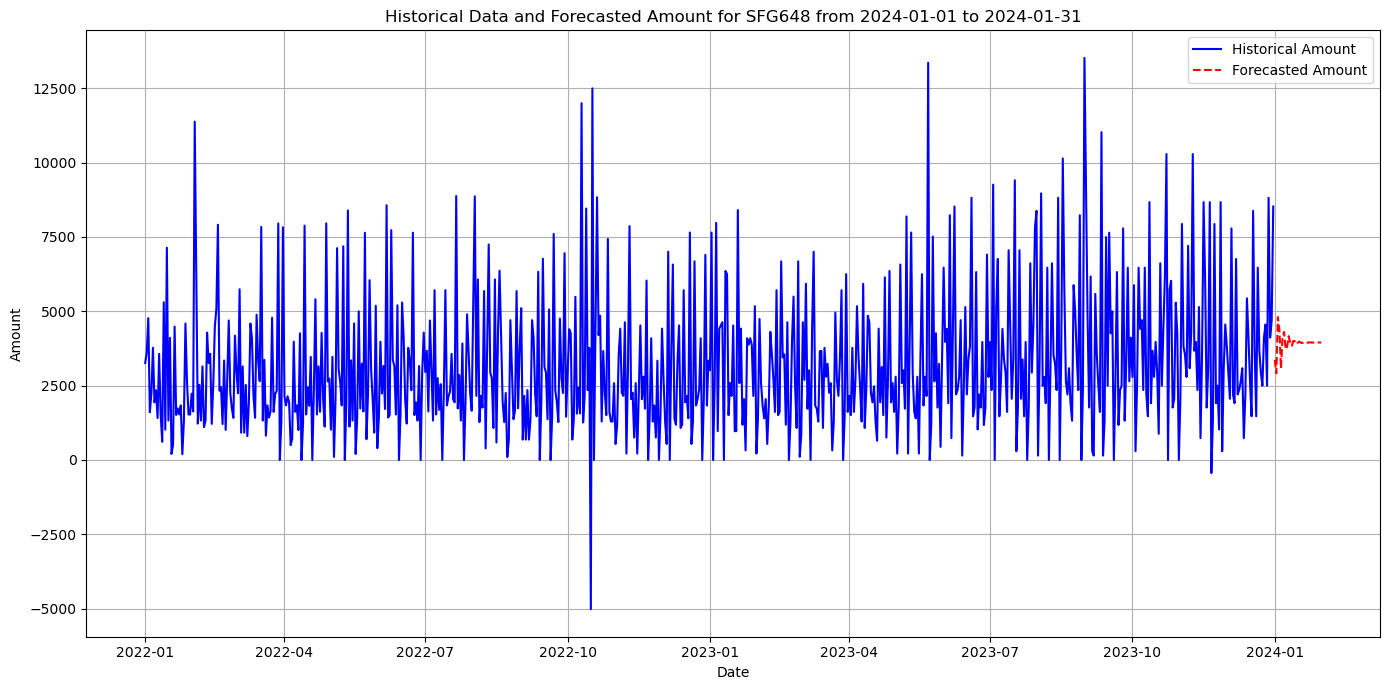

Item ID: SFG648 - Forecast saved to SFG648_forecast_jan2024.csv
Processing item ID: R00513
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16674.486, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17446.949, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17211.514, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17444.950, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16734.270, Time=0.75 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16663.007, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16902.955, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16660.601, Time=0.48 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16710.518, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16591.109, Time=2.56 sec
 ARIMA(4,1,2)

C:\Users\Vishwa.Pujara\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Vishwa.Pujara\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 amount   No. Observations:                  730
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -8177.096
Date:                Tue, 17 Sep 2024   AIC                          16372.193
Time:                        21:48:00   BIC                          16413.518
Sample:                    01-01-2022   HQIC                         16388.138
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6551      0.096    -17.167      0.000      -1.844      -1.466
ar.L2         -1.8270      0.082    -22.148      0.000      -1.989      -1.665
ar.L3         -1.3377      0.110    -12.139      0.0

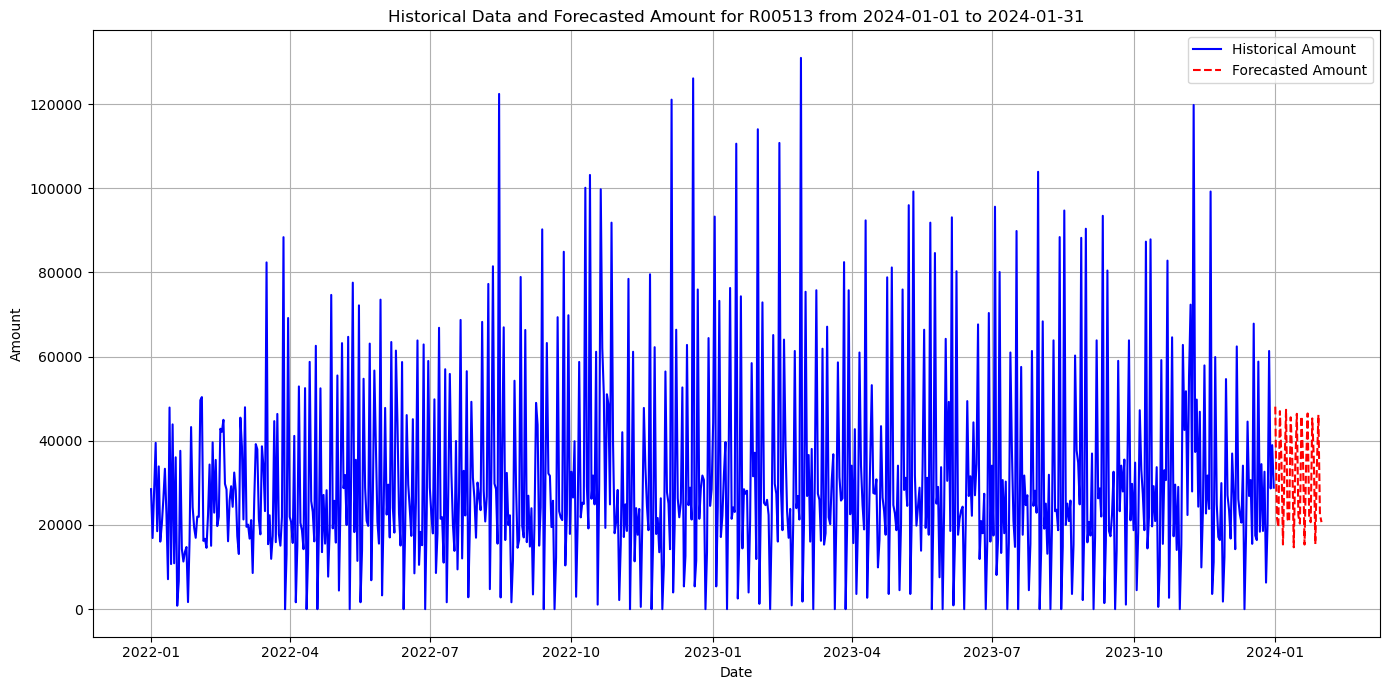

Item ID: R00513 - Forecast saved to R00513_forecast_jan2024.csv
Processing item ID: SFG152
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14290.831, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14082.911, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14288.833, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13844.015, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13732.770, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=13731.576, Time=0.29 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=13728.820, Time=0.31 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=13726.820, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=13729.575, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0

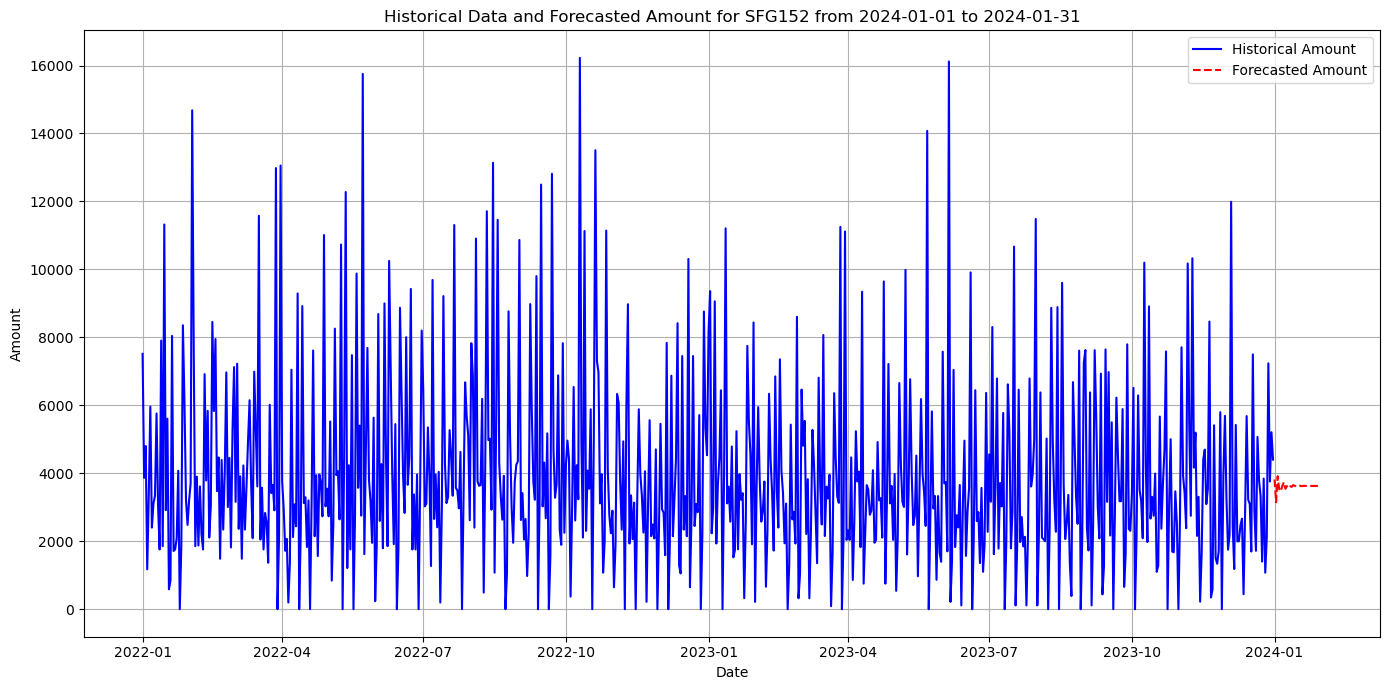

Item ID: SFG152 - Forecast saved to SFG152_forecast_jan2024.csv
Processing item ID: A00123
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12142.679, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13017.678, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12711.271, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12312.370, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13015.682, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12159.848, Time=1.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12156.135, Time=1.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12157.042, Time=1.96 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12122.489, Time=2.53 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12119.127, Time=2.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=12165.952, Time=1.89 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=12119.196, Time=1.89 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12159.703, Time=0.99

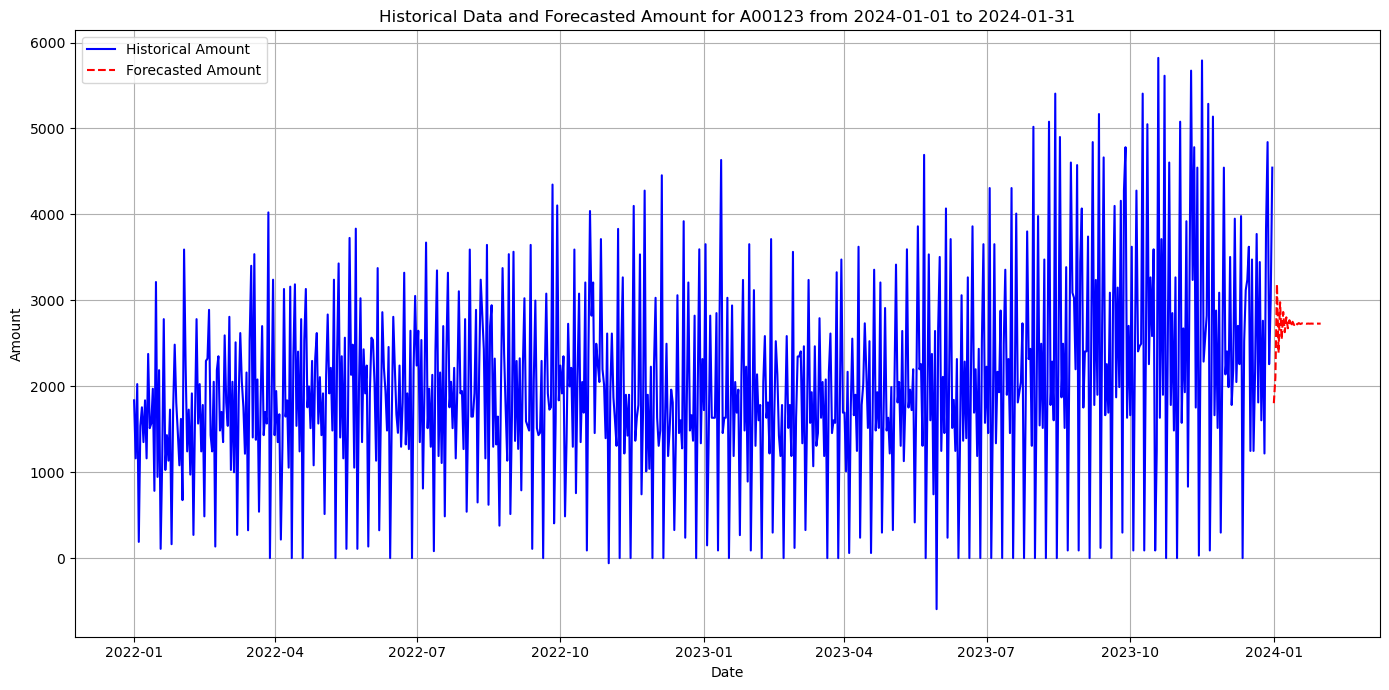

Item ID: A00123 - Forecast saved to A00123_forecast_jan2024.csv


In [40]:
def process_top_items_for_future(df, top_n=4, forecast_start_date='2024-01-01', forecast_end_date='2024-01-31'):
    # Determine the frequency of each item_id
    item_counts = df['itemid'].value_counts()
    
    # Select the top N item_ids with the highest frequency
    top_items = item_counts.head(top_n).index
    
    for item_id in top_items:
        # Forecast for each item_id
        print(f"Processing item ID: {item_id}")
        forecast_df = forecast_future_period(df, item_id, start_date=forecast_start_date, end_date=forecast_end_date)
        # Optionally, save the forecast_df to CSV (already done inside forecast_future_period function)
        # Print the forecasted DataFrame
        print(f"Item ID: {item_id} - Forecast saved to {item_id}_forecast_jan2024.csv")

# Load data and process the top items for forecasting future period
df = pd.read_csv('Downloads/hocco_sales_data_23 1.csv')
process_top_items_for_future(df)
